In [ ]:
from rdkit import Chem
import pyaniasetools as pya

from ase_interface import ANIENS,ensemblemolecule
import hdnntools as hdt
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import  ase
from ase.optimize import BFGS, LBFGS

import time

In [2]:
nets = dict()

ntdir = '/home/jsmith48/scratch/ANI-2x_retrain/ani-2x-1/'
#ntdir = '/home/jsmith48/scratch/transfer_learning/train_ens_DFTTZ/'
nets['ANI-2x']= {'cns' : ntdir + 'rHCNOSFCl-4.6R_16-3.1A_a4-8.params',
                 'sae' : ntdir + 'sae_linfit.dat',
                 'nnf' : ntdir + 'train',
                 'Nn'  : 8}

In [3]:
ens = ensemblemolecule(nets['ANI-2x']['cns'], nets['ANI-2x']['sae'], nets['ANI-2x']['nnf'], nets['ANI-2x']['Nn'], 1)

In [4]:
mol = Chem.MolFromMolFile('/home/jsmith48/scratch/ANI-2x_retrain/dhl_test/thienyl-pyridine-2-2.mol', removeHs=False)

ts = pya.ani_tortion_scanner(ens, fmax=0.001, printer=True)

torsions = {'Phi':[6, 2, 8, 16]}

st = time.time()
p,e,s = ts.scan_tortion(mol, torsions, 10.0, 37)
print(time.time()-st)

/apps/ase/ase/atoms.py:1358: UserWarning: Please use new API (which will return the angle in degrees): atoms_obj.get_dihedral(a1,a2,a3,a4)*pi/180 instead of atoms_obj.get_dihedral([a1,a2,a3,a4])
  'Please use new API (which will return the angle in degrees): '


Phi value (degrees), energy (kcal/mol), sigma=  [180.0] -501992.09 0.53
Phi value (degrees), energy (kcal/mol), sigma=  [189.99999988570679] -501991.91 0.53
Phi value (degrees), energy (kcal/mol), sigma=  [200.00000230049736] -501991.38 0.51
Phi value (degrees), energy (kcal/mol), sigma=  [209.99999627596645] -501990.53 0.49
Phi value (degrees), energy (kcal/mol), sigma=  [219.99999595303456] -501989.41 0.47
Phi value (degrees), energy (kcal/mol), sigma=  [229.99999533121243] -501988.14 0.47
Phi value (degrees), energy (kcal/mol), sigma=  [239.99999083896077] -501986.94 0.47
Phi value (degrees), energy (kcal/mol), sigma=  [250.00000532107293] -501986.24 0.46
Phi value (degrees), energy (kcal/mol), sigma=  [259.99999765302266] -501986.13 0.45
Phi value (degrees), energy (kcal/mol), sigma=  [270.00002982752494] -501986.16 0.45
Phi value (degrees), energy (kcal/mol), sigma=  [280.0000000983888] -501986.18 0.48
Phi value (degrees), energy (kcal/mol), sigma=  [290.00000596726386] -501986.25

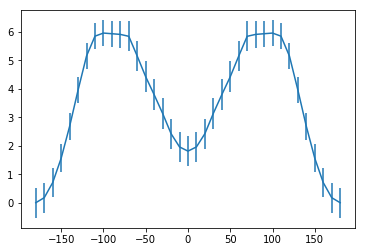

In [5]:
plt.errorbar(p,e-e.min(),yerr=s)
plt.show()

In [ ]:
X_tmp, S = pya.__convert_rdkitconfs_to_nparr__(mol)
print(idx)
hdt.writexyzfile('/home/jsmith48/scratch/ANI-2x_retrain/dhl_test/test_dhl.xyz',ts.X,list(S))

In [ ]:
from scipy.ndimage import zoom 

n_zoom = 8
data_x = zoom(p[:,:,0],n_zoom,order=1)
data_y = zoom(p[:,:,1],n_zoom,order=1)
data_z = zoom(e-e.min(),n_zoom,order=1)

fig = plt.figure(figsize=(18,12))
plt.style.use('seaborn-white')
contours = plt.contour(data_x, data_y, data_z, 30, colors='black')
plt.clabel(contours, inline=True, fontsize=12)

im1 = plt.imshow(data_z.T, extent=[data_x.min(), data_x.max(), data_y.min(), data_y.max()], origin='lower',
           cmap='nipy_spectral', alpha=1.0, interpolation='gaussian')

print(im1)
plt.xlabel('Phi',fontsize=22)
plt.ylabel('Psi',fontsize=22)

plt.colorbar()
plt.axis(aspect='image');

In [ ]:
n_zoom = 20

data_x = zoom(p[:,:,0],n_zoom,order=1)
data_y = zoom(p[:,:,1],n_zoom,order=1)
data_z = zoom(s,n_zoom,order=1)

fig = plt.figure(figsize=(18,12))
plt.style.use('seaborn-white')
contours = plt.contour(data_x, data_y, data_z, 10, colors='black')
plt.clabel(contours, inline=True, fontsize=12)

im1 = plt.imshow(data_z.T, extent=[data_x.min(), data_x.max(), data_y.min(), data_y.max()], origin='lower',
           cmap='nipy_spectral', alpha=1.0, interpolation='gaussian')

print(im1)

plt.colorbar()
plt.axis(aspect='image');

In [ ]:
def get_angle_pos(find_idx,rho):
    ids = []
    for i,ps in enumerate(rho):
        for j,pe in enumerate(ps):
            if np.allclose(np.array(find_idx),pe):
                ids.append((i,j))
    return ids

In [ ]:
pos1 = get_angle_pos([-90.0,60.0],p)
pos2 = get_angle_pos([-150.0,150.0],p)
pos3 = get_angle_pos([60.0,-90.0],p)
print(pos1+pos2+pos3)

In [ ]:
E = []
D = []
for ind in pos1+pos2+pos3:
    ase_mol = pya.__convert_rdkitmol_to_aseatoms__(mol)
    ase_mol.set_positions(ts.X[ind])
    ase_mol.set_calculator(ANIENS(ens))
    dyn = LBFGS(ase_mol, logfile='out.log')
    dyn.run(fmax=0.0005)
    E.append(ase_mol.get_potential_energy())
    D.append(np.array([ase_mol.get_dihedral(torsions['Phi'])*180.0/np.pi,ase_mol.get_dihedral(torsions['Psi'])*180.0/np.pi]))
E = np.array(E)
D = np.stack(D)
print(E)
print(D)

In [ ]:
hdt.evtokcal*(E-E.min())

In [ ]:
D[np.where(D>180.0)] = D[np.where(D>180.0)]-360.0

In [ ]:
D